#**Step 0: Load Dataset**

**Import library**

Fisrt of all, I import all the neccecery libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import F1Score

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


**Loading dataset**

Load the development dataset

In [2]:
# Load the development dataset
development_df = pd.read_csv('/content/development.csv')

print(development_df.head())

        age   sex            dzgroup             dzclass  num.co   edu  \
0  44.32599  male                CHF  COPD/CHF/Cirrhosis       2  14.0   
1  78.39600  male               COPD  COPD/CHF/Cirrhosis       2  14.0   
2  32.44098  male  ARF/MOSF w/Sepsis            ARF/MOSF       1  11.0   
3  74.93994  male  ARF/MOSF w/Sepsis            ARF/MOSF       0   8.0   
4  61.67599  male       Colon Cancer              Cancer       1   8.0   

       income  scoma    charges       totcst  ...    sod        ph glucose  \
0  under $11k    0.0    44950.0   23775.2188  ...  129.0       NaN   154.0   
1    $25-$50k    0.0    11293.0    8076.2969  ...  133.0  7.369141     NaN   
2         NaN   37.0  1273347.0  633212.0000  ...  143.0  7.509766     NaN   
3    $11-$25k    9.0    48671.0   31515.9844  ...  137.0  7.399414   146.0   
4    $11-$25k    0.0     2958.0    1935.3555  ...  137.0  7.469727   383.0   

     bun   urine  adlp  adls    adlsc  death  Id  
0   51.0  2650.0   0.0   0.0  0.000

first I create a copy from the developement dataframe and I will work on that. This is a deep copy which means that a new DataFrame is created, and the data is not just referenced but fully duplicated. Any modifications made to dev_data will not affect development_df and vice versa.

In [3]:
dev_data = development_df.copy()

print("The dimensions of the data is: ", dev_data.shape)
print(dev_data.info())

The dimensions of the data is:  (7284, 44)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7284 entries, 0 to 7283
Data columns (total 44 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       7284 non-null   float64
 1   sex       7284 non-null   object 
 2   dzgroup   7284 non-null   object 
 3   dzclass   7284 non-null   object 
 4   num.co    7284 non-null   int64  
 5   edu       5969 non-null   float64
 6   income    4865 non-null   object 
 7   scoma     7283 non-null   float64
 8   charges   7156 non-null   float64
 9   totcst    6575 non-null   float64
 10  totmcst   4506 non-null   float64
 11  avtisst   7218 non-null   float64
 12  race      7251 non-null   object 
 13  sps       7283 non-null   float64
 14  aps       7283 non-null   float64
 15  surv2m    7283 non-null   float64
 16  surv6m    7283 non-null   float64
 17  hday      7284 non-null   int64  
 18  diabetes  7284 non-null   int64  
 19  dementia  7284 non-null   

#**Step 1: Data exploration and visualization**

In this part I work on the date to have better pont of view. I check the ratio of target value,

In [4]:
# Separate features and target of development dataset
X_dev = dev_data.drop(columns=['death'])
y_dev = dev_data['death']

In [5]:
# Drop Id column
X_dev = X_dev.drop(columns=['Id'])

Here I will check the ratio between death and survived. Value 1 related to death and value 0 related to survived

In [6]:
# Ratio between death and survived
target = y_dev.value_counts()
print(target)

death
1    4974
0    2310
Name: count, dtype: int64


The number of death peaple is almost twice of the survived peaple. This is shown that the dataset is not balanced and need to be balanced. At the following I plot it.

<Axes: title={'center': 'Distribution target classes'}>

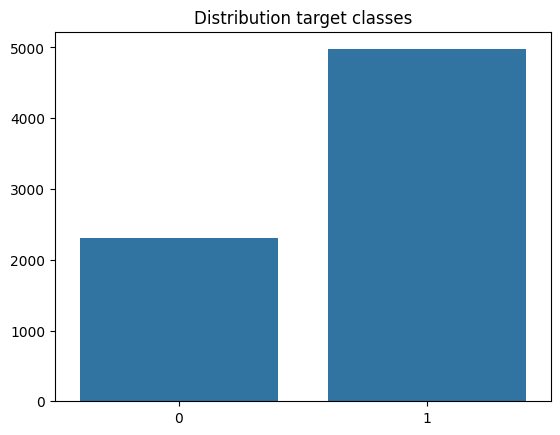

In [7]:
# Plot distribution target classes
unique, counts = np.unique(y_dev, return_counts=True)
plt.title('Distribution target classes')
sns.barplot(x=unique, y=counts)

Now I check the missing value

In [8]:
# Check for missing values
print(X_dev.isnull().sum())
print(y_dev.isnull().sum())

age            0
sex            0
dzgroup        0
dzclass        0
num.co         0
edu         1315
income      2419
scoma          1
charges      128
totcst       709
totmcst     2778
avtisst       66
race          33
sps            1
aps            1
surv2m         1
surv6m         1
hday           0
diabetes       0
dementia       0
ca             0
prg2m       1305
prg6m       1292
dnr           25
dnrday        25
meanbp         0
wblc         174
hrt            0
resp           0
temp           0
pafi        1855
alb         2683
bili        2078
crea          50
sod            0
ph          1816
glucose     3593
bun         3468
urine       3877
adlp        4516
adls        2296
adlsc          0
dtype: int64
0


I chech dataset data type of the dataset, it will hel for for preprocessing step to do normalzation and transform categorical features

float64    31
object      7
int64       4
Name: count, dtype: int64


<Axes: ylabel='count'>

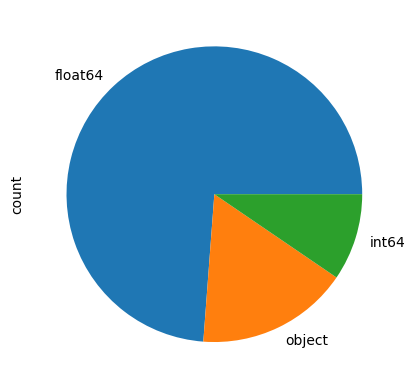

In [9]:
# Check features data type
print(X_dev.dtypes.value_counts())
X_dev.dtypes.value_counts().plot.pie()

In [10]:
# Identify categorical and numerical columns
cat_columns = X_dev.select_dtypes(include=['object'])
num_columns = X_dev.select_dtypes(include=['int64', 'float64'])

In [11]:
cat_columns

,sex,dzgroup,dzclass,income,race,ca,dnr
0,male,CHF,COPD/CHF/Cirrhosis,under $11k,black,no,no dnr
1,male,COPD,COPD/CHF/Cirrhosis,$25-$50k,white,yes,dnr after sadm
2,male,ARF/MOSF w/Sepsis,ARF/MOSF,NaN,white,no,no dnr
3,male,ARF/MOSF w/Sepsis,ARF/MOSF,$11-$25k,white,no,no dnr
4,male,Colon Cancer,Cancer,$11-$25k,black,metastatic,no dnr
...,...,...,...,...,...,...,...
7279,female,ARF/MOSF w/Sepsis,ARF/MOSF,$11-$25k,white,no,dnr after sadm
7280,male,CHF,COPD/CHF/Cirrhosis,under $11k,black,no,no dnr
7281,male,Cirrhosis,COPD/CHF/Cirrhosis,>$50k,white,no,no dnr
7282,male,Lung Cancer,Cancer,>$50k,white,metastatic,no dnr


Now I visualize the some statistics abot each feature

In [12]:
# Loop over each numerical feature in the dataset
for column in num_columns.columns:
    # Calculate summary statistics for the column
    summary_statistics = num_columns[column].describe()
    print(f"Summary statistics for the variable '{column}':")
    print(summary_statistics)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

    axes[0].hist(num_columns[column], bins=20, color='skyblue', edgecolor='black')
    axes[0].set_title(f'Histogram for {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')

    sns.boxplot(x=num_columns[column], color='skyblue', ax=axes[1])
    axes[1].set_title(f'Boxplot for {column}')
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

    # Display the number of missing values for the column
    missing_values = num_columns[column].isnull().sum()
    print(f"\n Number of missing values for '{column}': {missing_values}\n")

In [13]:
# Loop over each categorical feature in the dataset
for column in cat_columns.columns:
    # Print summary statistics for the categorical variable
    print(f"Summary statistics for the variable '{column}':")
    print(cat_columns[column].describe())

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    sns.countplot(x=column, data=cat_columns)
    axes.set_title(f'Bar chart for {column}')
    axes.set_xlabel(column)
    axes.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Display the number of missing values for the column
    missing_values = cat_columns[column].isnull().sum()
    print(f"\nNumber of missing values for '{column}': {missing_values}\n")

In [14]:
death_patients = dev_data[dev_data['death']== 1]
survived_patients = dev_data[dev_data['death']== 0]

In [15]:
for col in num_columns:
    plt.figure()
    sns.histplot(death_patients[col], label='death', kde=True, stat="density")
    sns.histplot(survived_patients[col], label='survive', kde=True, stat="density")
    plt.legend()
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

In [16]:
for col in cat_columns :
    plt.figure()
    sns.heatmap(pd.crosstab(dev_data['death'], dev_data[col]), annot=True, fmt='d')

Some key point from analyzing the results above:

The number of deaths of males is higher than females. those with ARF/MOSF w/Sepsis Acute kidney injury (AKI)/multiple organ dysfunction syndrome (MOFS) with sepsis are more likely to die< Those earning less than $11K per year are more likely to die, perhaps due to the inability to pay hospital bills and medical care. White race has higher death probability Those who have metastatic cancer, that is, cancer that has spread throughout the body, are more likely to die.

#**Step 2: Data Preprocessing**

In this part I want do some preprocessing method due to data exploration and visualization part:

1) Drop unnecessary and correalted features

2) Handle Missing value

3) Encoding categorical variables

4) Normalization

Correaltion between columns

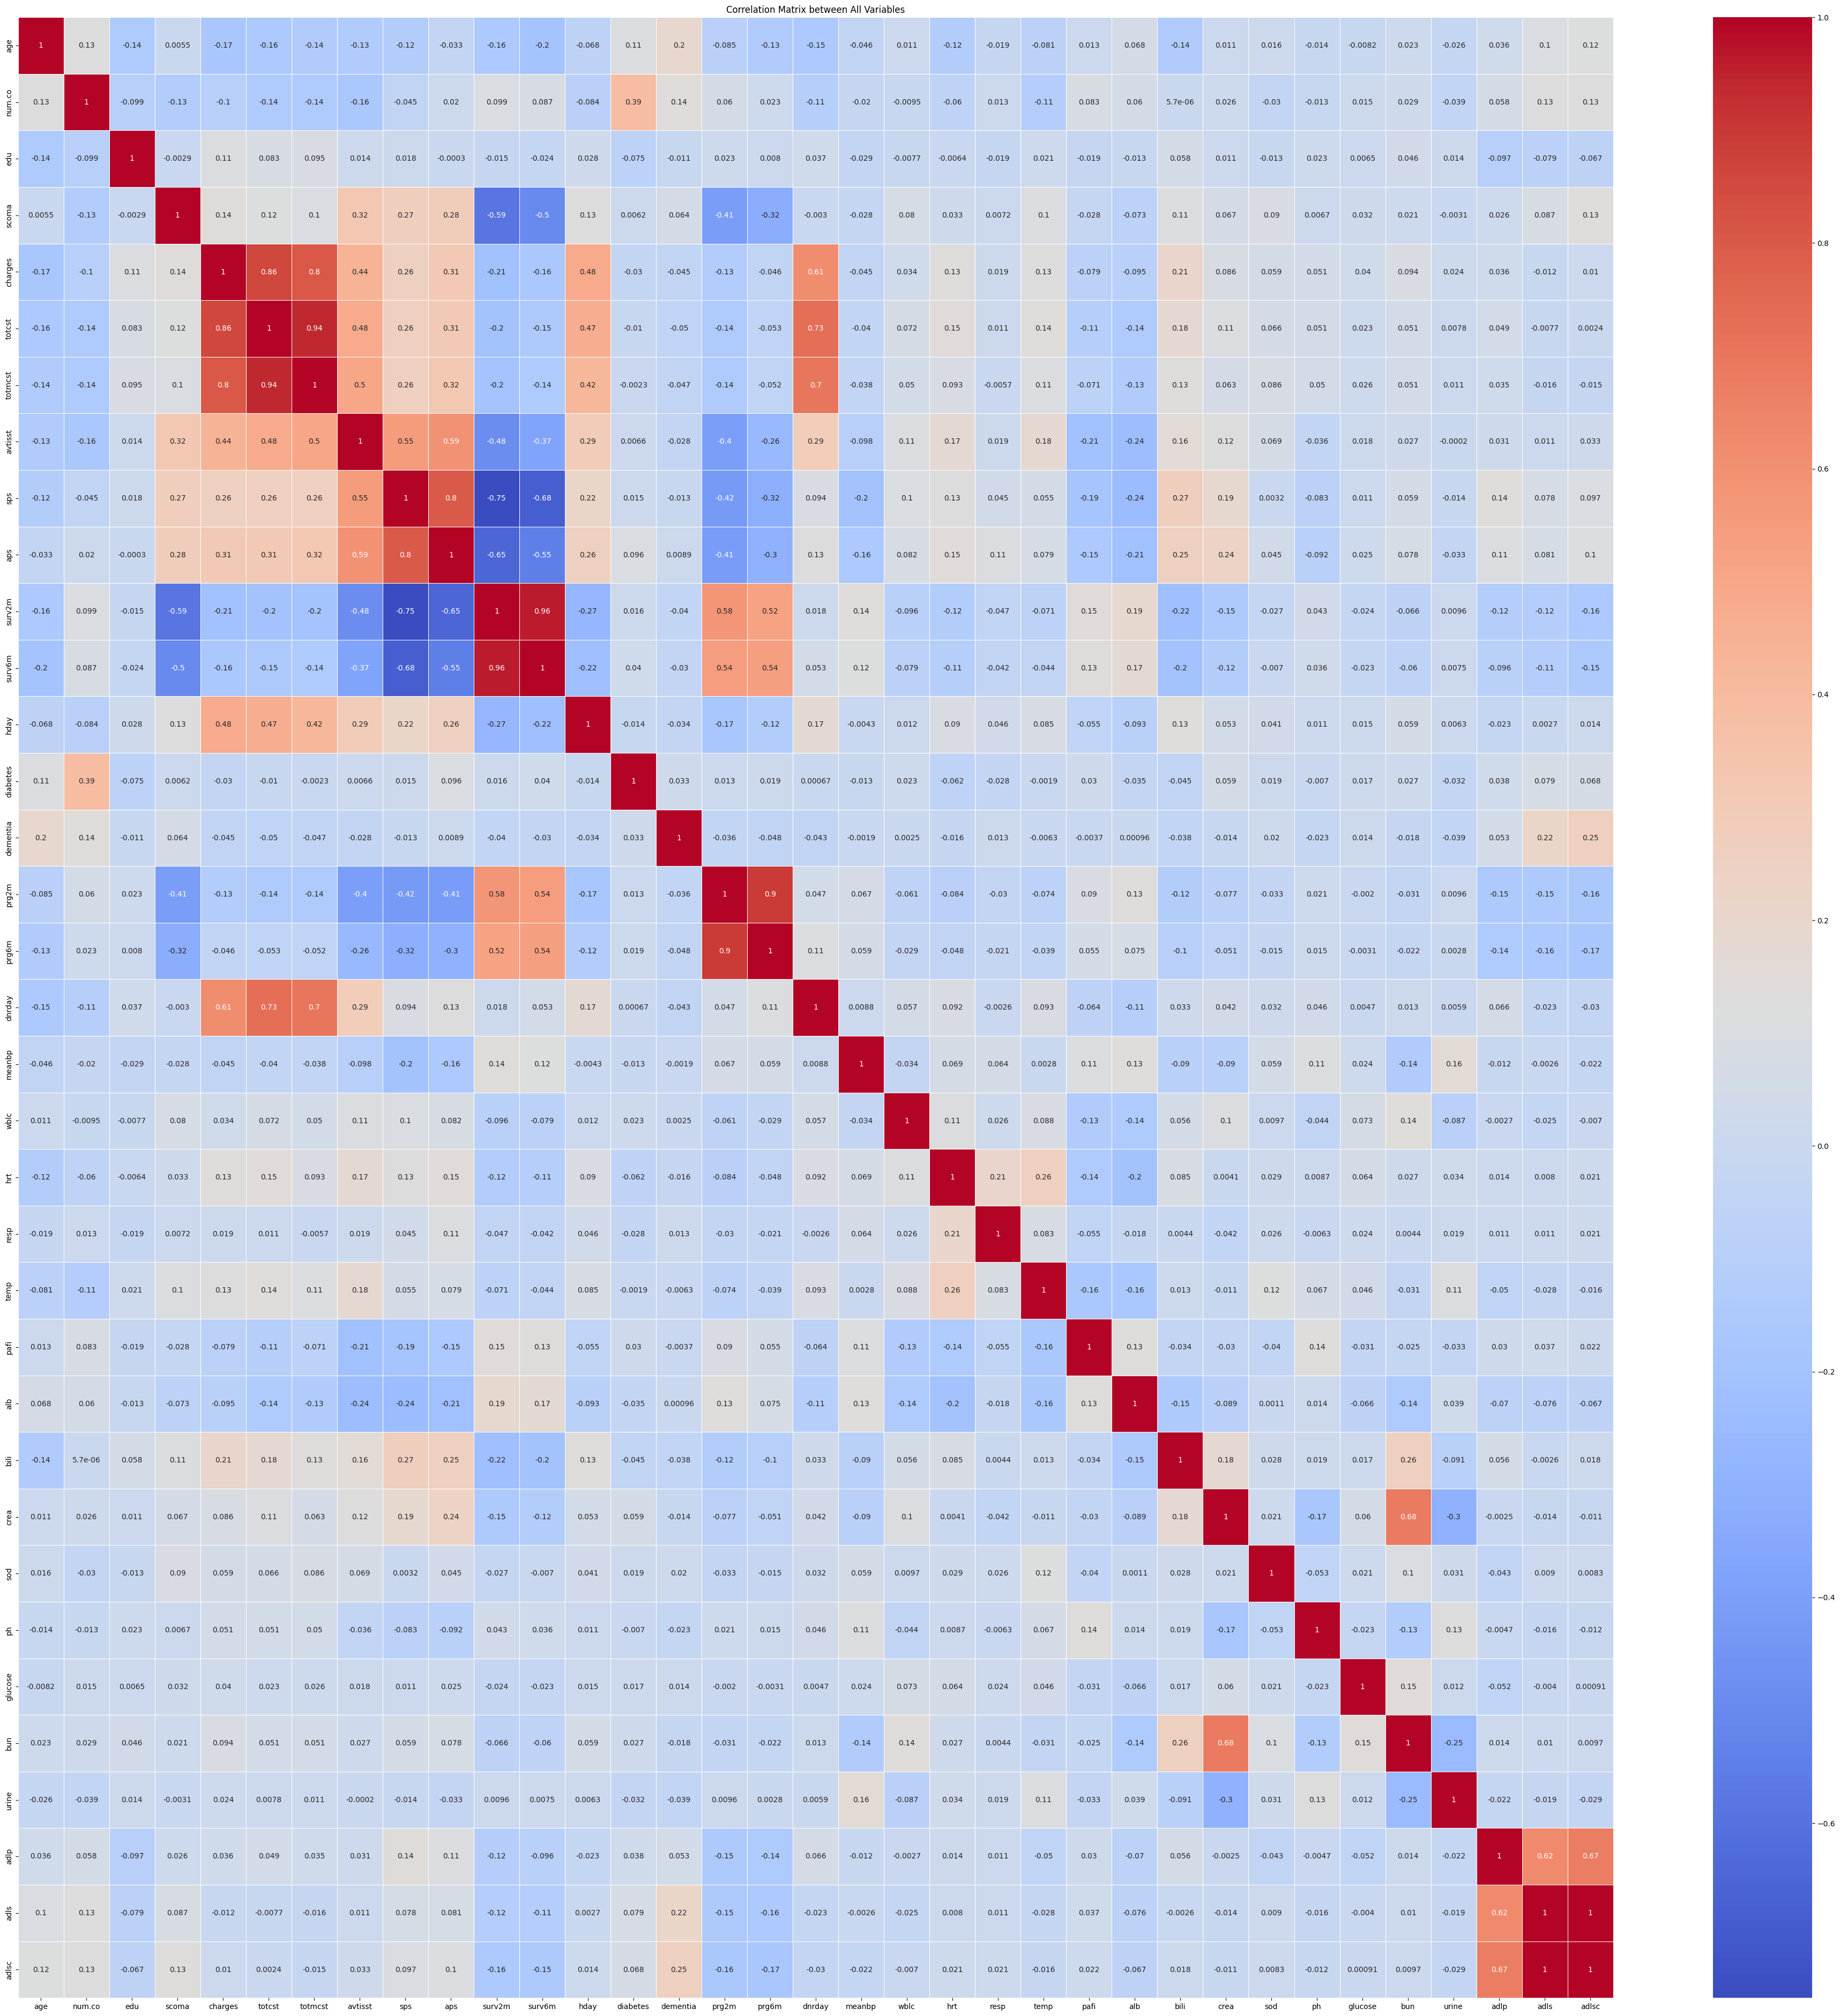

In [17]:
# Displaying the correlation matrix
plt.figure(figsize=(48, 48))
sns.heatmap(num_columns.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix between All Variables')
plt.show()

Drop correlatd and unnecessary features

In [18]:
# X_dev = X_dev.drop(['adls','aps', 'sps', 'surv2m', 'surv6m','prg2m', 'prg6m', 'dnrday', 'totcst', 'totmcst','dzclass'], axis=1)
X_dev = X_dev.drop(['totcst', 'totmcst','sps', 'surv2m', 'prg2m', 'dnrday', 'adls', 'adlsc', 'dzclass' ], axis=1)

-----------------------------------------------------------------

Handle missing value

In [19]:
null_columns = X_dev.columns[X_dev.isnull().any()]
null_columns

Index(['edu', 'income', 'scoma', 'charges', 'avtisst', 'race', 'aps', 'surv6m',
       'prg6m', 'dnr', 'wblc', 'pafi', 'alb', 'bili', 'crea', 'ph', 'glucose',
       'bun', 'urine', 'adlp'],
      dtype='object')

['edu', 'income', 'charges', 'avtisst', 'race', 'dnr', 'meanbp', 'wblc',
       'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph',
       'glucose', 'bun', 'urine', 'adlp'],

In [20]:
edu_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
income_imputer = SimpleImputer(missing_values= np.nan, strategy='most_frequent')
scoma_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
charges_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
avtisst_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
race_imputer = SimpleImputer(missing_values= np.nan, strategy='most_frequent')
aps_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
surv6m_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
prg6m_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
dnr_imputer = SimpleImputer(missing_values= np.nan, strategy='most_frequent')
wblc_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
pafi_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
alb_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
bili_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
crea_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
ph_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
glucose_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
bun_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
urine_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
adlp_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')

In [21]:
ct= ColumnTransformer(transformers=[
      ('edu_imputer', edu_imputer, ['edu']),
      ('income_imputer', income_imputer, ['income']),
      ('scoma_imputer', scoma_imputer, ['scoma']),
      ('charges_imputer', charges_imputer, ['charges']),
      ('avtisst_imputer', avtisst_imputer, ['avtisst']),
      ('race_imputer', race_imputer, ['race']),
      ('aps_imputer', aps_imputer, ['aps']),
      ('surv6m_imputer', surv6m_imputer, ['surv6m']),
      ('prg6m_imputer', prg6m_imputer, ['prg6m']),
      ('dnr_imputer', dnr_imputer, ['dnr']),
      ('wblc_imputer', wblc_imputer, ['wblc']),
      ('pafi_imputer', pafi_imputer, ['pafi']),
      ('alb_imputer', alb_imputer, ['alb']),
      ('bili_imputer', bili_imputer, ['bili']),
      ('crea_imputer', crea_imputer, ['crea']),
      ('ph_imputer', ph_imputer, ['ph']),
      ('glucose_imputer', glucose_imputer, ['glucose']),
      ('bun_imputer', bun_imputer, ['bun']),
      ('urine_imputer', urine_imputer, ['urine']),
      ('adlp_imputer', adlp_imputer, ['adlp'])
])

In [22]:
# Save the original data types:
original_dtypes = X_dev.dtypes
X_dev_transformed = pd.DataFrame(ct.fit_transform(X_dev), columns=['edu', 'income', 'scoma', 'charges', 'avtisst', 'race',
                                                                   'aps', 'surv6m', 'prg6m', 'dnr', 'wblc', 'pafi', 'alb',
                                                                   'bili', 'crea', 'ph', 'glucose', 'bun', 'urine', 'adlp'])
for col in X_dev_transformed.columns:
 X_dev_transformed[col] = X_dev_transformed[col].astype(original_dtypes[col])

X_dev[['edu', 'income', 'scoma', 'charges', 'avtisst', 'race',
       'aps', 'surv6m', 'prg6m', 'dnr', 'wblc', 'pafi', 'alb',
       'bili', 'crea', 'ph', 'glucose', 'bun', 'urine', 'adlp']] = X_dev_transformed

In [23]:
X_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7284 entries, 0 to 7283
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       7284 non-null   float64
 1   sex       7284 non-null   object 
 2   dzgroup   7284 non-null   object 
 3   num.co    7284 non-null   int64  
 4   edu       7284 non-null   float64
 5   income    7284 non-null   object 
 6   scoma     7284 non-null   float64
 7   charges   7284 non-null   float64
 8   avtisst   7284 non-null   float64
 9   race      7284 non-null   object 
 10  aps       7284 non-null   float64
 11  surv6m    7284 non-null   float64
 12  hday      7284 non-null   int64  
 13  diabetes  7284 non-null   int64  
 14  dementia  7284 non-null   int64  
 15  ca        7284 non-null   object 
 16  prg6m     7284 non-null   float64
 17  dnr       7284 non-null   object 
 18  meanbp    7284 non-null   float64
 19  wblc      7284 non-null   float64
 20  hrt       7284 non-null   floa

In [24]:
X_dev.columns

Index(['age', 'sex', 'dzgroup', 'num.co', 'edu', 'income', 'scoma', 'charges',
       'avtisst', 'race', 'aps', 'surv6m', 'hday', 'diabetes', 'dementia',
       'ca', 'prg6m', 'dnr', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi',
       'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp'],
      dtype='object')

-----------------------------------------------------------------

Encoding categorical variables

I will encode categorical features according to the nature of each one. If the feature has an important order between its values I use ordinalEncoding, if it does not have an order between its values I opt for oneHotEncoding

In [25]:
col_cats_name= list(cat_columns.columns)
col_cats_name

['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'dnr']

As shown in the dataset, the values ​​of the patient income column have an order between them.

In [26]:
col_cats_name.pop(2)

'dzclass'

In [27]:
col_cats_name

['sex', 'dzgroup', 'income', 'race', 'ca', 'dnr']

In [28]:
col_cats_name.pop(2)

'income'

In [29]:
col_cats_name

['sex', 'dzgroup', 'race', 'ca', 'dnr']

In [30]:
X_dev['income'] = X_dev['income'].replace({
    'under $11k': 0,
    '$11-$25k': 1,
    '$25-$50k': 2,
    '>$50k': 3
})

As the sex feature only takes two different values, I encode it using OrdinalEncoding .

In [31]:
encoder = OrdinalEncoder()
X_dev[['sex']] = encoder.fit_transform(X_dev[['sex']]).astype('int')

In [32]:
col_cats_name.pop(0)

'sex'

In [33]:
col_cats_name

['dzgroup', 'race', 'ca', 'dnr']

In [34]:
X_dev = pd.get_dummies(X_dev, columns=col_cats_name)

In [35]:
X_dev.shape

(7284, 48)

In [36]:
X_dev.columns

Index(['age', 'sex', 'num.co', 'edu', 'income', 'scoma', 'charges', 'avtisst',
       'aps', 'surv6m', 'hday', 'diabetes', 'dementia', 'prg6m', 'meanbp',
       'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod',
       'ph', 'glucose', 'bun', 'urine', 'adlp', 'dzgroup_ARF/MOSF w/Sepsis',
       'dzgroup_CHF', 'dzgroup_COPD', 'dzgroup_Cirrhosis',
       'dzgroup_Colon Cancer', 'dzgroup_Coma', 'dzgroup_Lung Cancer',
       'dzgroup_MOSF w/Malig', 'race_asian', 'race_black', 'race_hispanic',
       'race_other', 'race_white', 'ca_metastatic', 'ca_no', 'ca_yes',
       'dnr_dnr after sadm', 'dnr_dnr before sadm', 'dnr_no dnr'],
      dtype='object')

In [37]:
# plt.figure(figsize=(46, 46))
# sns.heatmap(X_dev.corr(), annot=True, cmap='coolwarm', linewidths=.5)
# plt.title('Correlation Matrix between All Variables')
# plt.show()

By analyzing the matrix there is no correlation between our variables except for the variables which belong to the same basic column before the use of onehoteEncoding, which is logical.

-----------------------------------------------------------------

Data normalization

In [38]:
X_features = X_dev.copy()
y_target = y_dev.copy()

X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7284 entries, 0 to 7283
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        7284 non-null   float64
 1   sex                        7284 non-null   int64  
 2   num.co                     7284 non-null   int64  
 3   edu                        7284 non-null   float64
 4   income                     7284 non-null   int64  
 5   scoma                      7284 non-null   float64
 6   charges                    7284 non-null   float64
 7   avtisst                    7284 non-null   float64
 8   aps                        7284 non-null   float64
 9   surv6m                     7284 non-null   float64
 10  hday                       7284 non-null   int64  
 11  diabetes                   7284 non-null   int64  
 12  dementia                   7284 non-null   int64  
 13  prg6m                      7284 non-null   float

In [39]:
y_target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 7284 entries, 0 to 7283
Series name: death
Non-Null Count  Dtype
--------------  -----
7284 non-null   int64
dtypes: int64(1)
memory usage: 57.0 KB


In [40]:
cols_to_scale = ['age', 'num.co', 'edu', 'income', 'scoma', 'charges', 'avtisst', 'aps', 'surv6m', 'hday', 'prg6m', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp']

In [41]:
#StandardScaler
scaler = StandardScaler()

#The transformed data is assigned back to X_train, replacing the original values with scaled values.
X_features[cols_to_scale] =  scaler.fit_transform(X_features[cols_to_scale].values)


In [42]:
X_features.head(5)

,age,sex,num.co,edu,income,scoma,charges,avtisst,aps,surv6m,...,race_black,race_hispanic,race_other,race_white,ca_metastatic,ca_no,ca_yes,dnr_dnr after sadm,dnr_dnr before sadm,dnr_no dnr
0,-1.173371,1,0.092620,0.727218,-0.650586,-0.495580,-0.146062,-0.628134,0.115393,0.478716,...,True,False,False,False,False,True,False,False,False,True
1,1.008088,1,0.092620,0.727218,1.437480,-0.495580,-0.471511,-0.539291,0.266174,0.427692,...,False,False,False,True,False,False,True,True,False,False
2,-1.934353,1,-0.649563,-0.228897,-0.650586,1.002798,11.732002,1.212195,0.316434,-0.226954,...,False,False,False,True,False,True,False,False,False,True
3,0.786801,1,-1.391745,-1.185013,0.393447,-0.131110,-0.110082,0.146073,-0.135909,0.123955,...,False,False,False,True,False,True,False,False,False,True
4,-0.062473,1,-0.649563,-1.185013,0.393447,-0.495580,-0.552106,-0.577366,0.316434,-1.496654,...,True,False,False,False,True,False,False,False,False,True


Checking imbalnce

In [43]:
# Combine features and target into a single DataFrame
X_df = pd.concat([X_features, y_target], axis=1)
X_df.head(5)

,age,sex,num.co,edu,income,scoma,charges,avtisst,aps,surv6m,...,race_hispanic,race_other,race_white,ca_metastatic,ca_no,ca_yes,dnr_dnr after sadm,dnr_dnr before sadm,dnr_no dnr,death
0,-1.173371,1,0.092620,0.727218,-0.650586,-0.495580,-0.146062,-0.628134,0.115393,0.478716,...,False,False,False,False,True,False,False,False,True,1
1,1.008088,1,0.092620,0.727218,1.437480,-0.495580,-0.471511,-0.539291,0.266174,0.427692,...,False,False,True,False,False,True,True,False,False,1
2,-1.934353,1,-0.649563,-0.228897,-0.650586,1.002798,11.732002,1.212195,0.316434,-0.226954,...,False,False,True,False,True,False,False,False,True,1
3,0.786801,1,-1.391745,-1.185013,0.393447,-0.131110,-0.110082,0.146073,-0.135909,0.123955,...,False,False,True,False,True,False,False,False,True,0
4,-0.062473,1,-0.649563,-1.185013,0.393447,-0.495580,-0.552106,-0.577366,0.316434,-1.496654,...,False,False,False,True,False,False,False,False,True,1


In [44]:
class_counts = X_df['death'].value_counts()
print(class_counts)

death
1    4974
0    2310
Name: count, dtype: int64


In [45]:
class_1_count, class_0_count = X_df['death'].value_counts()
class_1_count, class_0_count

(4974, 2310)

I oversample the class (death equal to 1) in the DataFrame by creating a random sample of the majority class (death equal to 0) of the same size as the minority class. Then, it concatenates this oversampled sample with the minority class to obtain a balanced dataset in terms of classes. Finally, the code prints the class count in the new dataset to verify that it is balanced.

In [46]:
class_0 = X_df[X_df['death'] == 0]
class_0_oversampled = class_0.sample(class_1_count, replace=True)

# Concatenatenation of the resampled class: '>50K' and the dominant class '<=50K' in order to obtain the balanced dataset.
X_df_balanced = pd.concat([X_df[X_df['death'] == 1], class_0_oversampled], axis=0)

# Verification
class_counts = X_df_balanced['death'].value_counts()
print(class_counts)

death
1    4974
0    4974
Name: count, dtype: int64


In [47]:
X_df = X_df_balanced
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9948 entries, 0 to 6643
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        9948 non-null   float64
 1   sex                        9948 non-null   int64  
 2   num.co                     9948 non-null   float64
 3   edu                        9948 non-null   float64
 4   income                     9948 non-null   float64
 5   scoma                      9948 non-null   float64
 6   charges                    9948 non-null   float64
 7   avtisst                    9948 non-null   float64
 8   aps                        9948 non-null   float64
 9   surv6m                     9948 non-null   float64
 10  hday                       9948 non-null   float64
 11  diabetes                   9948 non-null   int64  
 12  dementia                   9948 non-null   int64  
 13  prg6m                      9948 non-null   float64
 1

In [48]:
X_df.isnull().sum()

age                          0
sex                          0
num.co                       0
edu                          0
income                       0
scoma                        0
charges                      0
avtisst                      0
aps                          0
surv6m                       0
hday                         0
diabetes                     0
dementia                     0
prg6m                        0
meanbp                       0
wblc                         0
hrt                          0
resp                         0
temp                         0
pafi                         0
alb                          0
bili                         0
crea                         0
sod                          0
ph                           0
glucose                      0
bun                          0
urine                        0
adlp                         0
dzgroup_ARF/MOSF w/Sepsis    0
dzgroup_CHF                  0
dzgroup_COPD                 0
dzgroup_

#**Step 3: Feature Selection**

Feature selection is an iterative process that aims to identify a subset of relevant variables from the dataset features.

In [ ]:
new_X_features = X_df.drop(columns=['death'])
new_y_target = X_df['death']

new_X_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9948 entries, 0 to 19
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        9948 non-null   float64
 1   sex                        9948 non-null   int64  
 2   num.co                     9948 non-null   float64
 3   edu                        9948 non-null   float64
 4   income                     9948 non-null   float64
 5   scoma                      9948 non-null   float64
 6   charges                    9948 non-null   float64
 7   avtisst                    9948 non-null   float64
 8   aps                        9948 non-null   float64
 9   surv6m                     9948 non-null   float64
 10  hday                       9948 non-null   float64
 11  diabetes                   9948 non-null   int64  
 12  dementia                   9948 non-null   int64  
 13  prg6m                      9948 non-null   float64
 14 

1.0


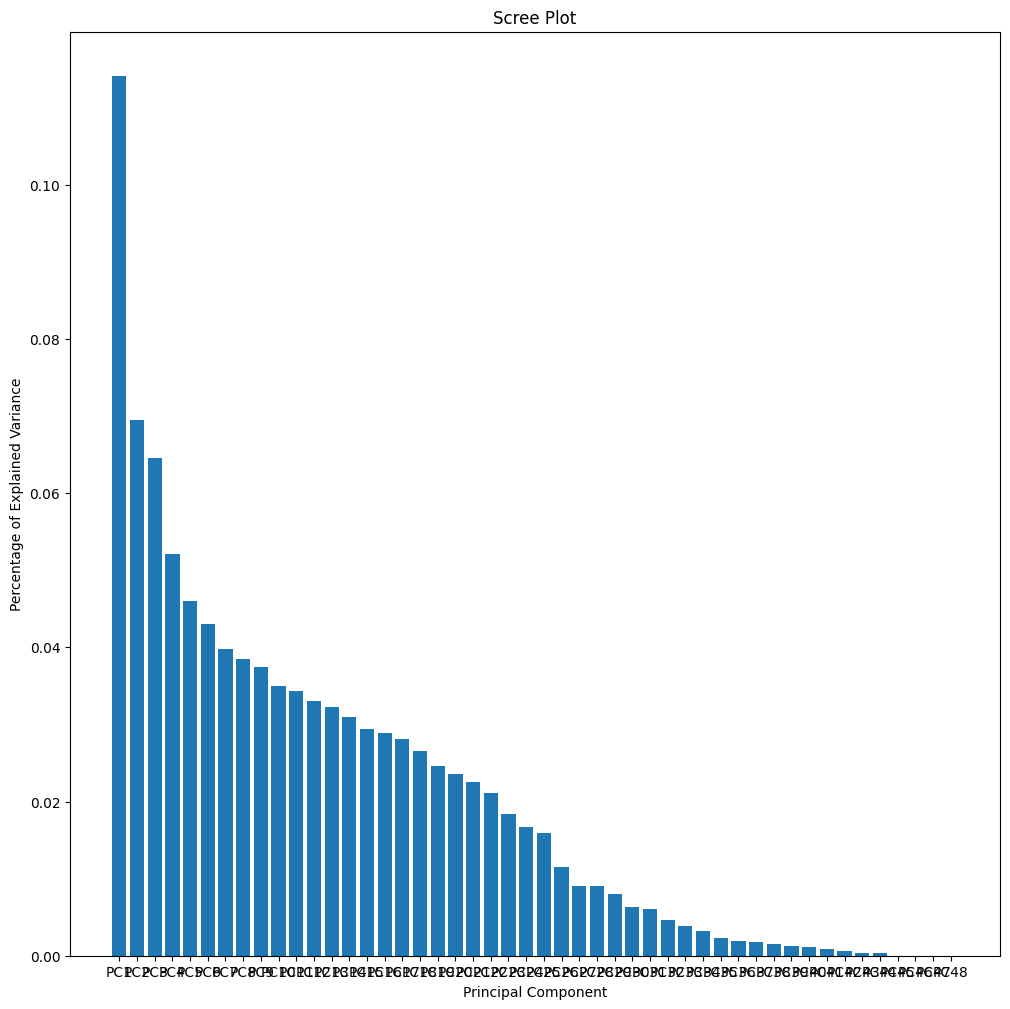

In [ ]:
#print the sum of the explained variance ratios of all principal components. It should be close to 1 (or 100%), indicating how much variance is captured by the PCA.
pca = PCA()
pca.fit_transform(new_X_features)
print(np.sum(pca.explained_variance_ratio_))

per_var = np.round(pca.explained_variance_ratio_,decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
plt.bar(x=range(1,len(pca.explained_variance_ratio_)+1), height=pca.explained_variance_ratio_, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

In [ ]:
list_components = []
for i in range(0,2):
    result_dict = {}
    for key, value in zip(new_X_features.columns, np.absolute(pca.components_[i])):
        result_dict[key] = value
    list_component = sorted(result_dict.items(), key=lambda x: x[1])
    list_components.append(list_component)

In [ ]:
list_components

[[('race_black', 3.738803809023944e-05),
  ('dnr_dnr before sadm', 0.0002509482990092669),
  ('dementia', 0.00028770760288644986),
  ('sex', 0.0010802356215756648),
  ('race_other', 0.002003352787688633),
  ('race_asian', 0.0022178837007101717),
  ('ca_no', 0.004799520113042683),
  ('dzgroup_Cirrhosis', 0.004951340452799013),
  ('race_hispanic', 0.005984426835780385),
  ('diabetes', 0.007227317900538197),
  ('race_white', 0.01024305136226942),
  ('dzgroup_Colon Cancer', 0.018136418961338826),
  ('income', 0.020075387873860956),
  ('dzgroup_Lung Cancer', 0.021747440373155444),
  ('ca_yes', 0.022428701074638024),
  ('dzgroup_Coma', 0.026502109861279502),
  ('ca_metastatic', 0.02722822118768074),
  ('dzgroup_MOSF w/Malig', 0.02895869469047976),
  ('ph', 0.03177407502789184),
  ('glucose', 0.03636617002063297),
  ('urine', 0.03690382783706423),
  ('dzgroup_COPD', 0.04167091880273079),
  ('adlp', 0.04355552954734604),
  ('age', 0.046009381591264116),
  ('edu', 0.04790016627292204),
  ('sod'

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

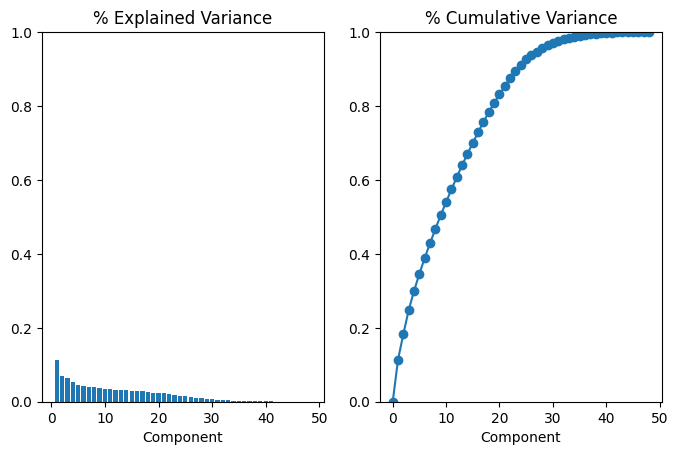

In [ ]:
# Look at explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
plot_variance(pca)

In [ ]:
# Get the explained variance ratio
explained_variance_ratio_std = pca.explained_variance_ratio_

cumulative_variance_std = np.cumsum(explained_variance_ratio_std)

m = np.argmax(cumulative_variance_std >= 0.99) + 1
print("m (Standardized Data):", m)

m' (Standardized Data): 35


In [ ]:
key_counts = Counter()
for data_list in list_components:
    sorted_data = sorted(data_list, key=lambda x: x[1], reverse=True)[:35]
    key_counts.update(dict(sorted_data).keys())

top_keys = [key for key, count in key_counts.most_common(35)]

print(top_keys)

['aps', 'avtisst', 'surv6m', 'charges', 'scoma', 'hday', 'prg6m', 'bili', 'alb', 'crea', 'hrt', 'temp', 'pafi', 'num.co', 'wblc', 'bun', 'dzgroup_ARF/MOSF w/Sepsis', 'dnr_no dnr', 'dnr_dnr after sadm', 'meanbp', 'dzgroup_CHF', 'resp', 'sod', 'edu', 'age', 'adlp', 'dzgroup_COPD', 'urine', 'glucose', 'ph', 'ca_yes', 'dzgroup_MOSF w/Malig', 'ca_metastatic', 'dzgroup_Coma', 'dzgroup_Lung Cancer']


In [ ]:
new_X_features = new_X_features[top_keys]

In [ ]:
new_X_features.head(5)

,aps,avtisst,surv6m,charges,scoma,hday,prg6m,bili,alb,crea,...,adlp,dzgroup_COPD,urine,glucose,ph,ca_yes,dzgroup_MOSF w/Malig,ca_metastatic,dzgroup_Coma,dzgroup_Lung Cancer
0,0.115393,-0.628134,0.478716,-0.146062,-0.495580,-0.373849,1.454030,-0.505312,-1.328318,0.499088,...,-1.085512,False,4.559313e-01,-0.084034,1.271090e-14,False,False,False,False,False
1,0.266174,-0.539291,0.427692,-0.471511,-0.495580,-0.373849,-1.616725,-0.483159,1.367909,-0.340698,...,0.000000,True,-4.529791e-16,0.000000,-6.614458e-01,True,False,False,False,False
2,0.316434,1.212195,-0.226954,11.732002,1.002798,5.949430,-0.713561,-0.350201,-0.852103,-0.640695,...,0.000000,False,-4.529791e-16,0.000000,1.351067e+00,False,False,False,False,False
4,0.316434,-0.577366,-1.496654,-0.552106,-0.495580,-0.373849,-1.797357,0.580273,0.000000,1.999071,...,0.000000,False,-1.147808e+00,3.577259,7.780611e-01,False,False,True,False,False
6,-1.241639,-1.415033,0.096037,-0.548303,-0.495580,-0.373849,-0.713561,-0.195104,0.000000,-0.700680,...,0.000000,False,-4.529791e-16,0.000000,1.057573e+00,False,False,True,False,False


#**Step 4: Build and Train Model**

###**Basic tasks of model training **

In [ ]:
X = new_X_features
y = new_y_target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,
                                                    random_state = 39,stratify=y)

###**Random Forest Classifier**

**Hyper parameter tuning**

In [ ]:
# # Define the search space
# param_grid_rfc = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }


# rfc_grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rcf, cv=5, n_jobs=-1, verbose=2)

# rfc_hyper_params_models = rfc_grid_search.fit(X_train, y_train)

# best_params_rfc = rfc_grid_search.best_params_

# print(Best Parameters: ", best_params_rfc)


**Best parameters**

In [ ]:
best_params_rfc = {'max_depth': 11,
                  'max_features': 'auto',
                  'min_samples_leaf': 1,
                  'min_samples_split': 2,
                   'random_state': 39,
                  'n_estimators': 120}

best_params_rfc

{'max_depth': 11,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 39,
 'n_estimators': 120}

**Train model**

In [ ]:
rfc = RandomForestClassifier(**best_params_rfc)
rfc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=11, max_features='auto', n_estimators=120,
                       random_state=39)

**Prediction and evaluation**

In [ ]:
y_pred = rfc.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("precision :", precision)
print("recall :", recall)
print("accuracy :", accuracy)
print("F1-score :", f1)

precision : 0.9253112033195021
recall : 0.7468184862692565
accuracy : 0.84321608040201
F1-score : 0.826538176426983


###**xgboost Classifier**

**Hyper parameter tuning**

In [ ]:
# # Define the search space
# param_grid_xgb = {
#  'n_estimators': [100, 200, 300, 500],
#  'learning_rate': [0.01, 0.05, 0.1],
#  'max_depth': [3, 5, 7],
#  'min_child_weight': [1, 3, 5],
#  'gamma': [0.01, 0.05, 0.1],
#  'subsample': [0.7, 0.8, 0.9],
#  'colsample_bytree': [0.7, 0.8, 0.9],
#  'reg_alpha': [0, 0.01, 0.05],
#  'reg_lambda': [0, 0.01, 0.05],
# }


# xgb_grid_search = GridSearchCV(XGBClassifier(), param_grid=param_grid_xgb, n_jobs=11, cv=5, scoring='accuracy', verbose=100)

# hyper_params_models = xgb_grid_search.fit(X_train, y_train)

# best_params_xgb = xgb_grid_search.best_params_

# print(Best Parameters: ", best_params_xgb)

**Best parameters**

In [ ]:
best_params_xgb = {'colsample_bytree': 0.8,
 'gamma': 0.05,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 3,

 'n_estimators': 500,
 'reg_alpha': 0.01,
 'reg_lambda': 0.01,
 'subsample': 0.8,
}

best_params_xgb

{'colsample_bytree': 0.8,
 'gamma': 0.05,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 500,
 'reg_alpha': 0.01,
 'reg_lambda': 0.01,
 'subsample': 0.8}

**Train model**

In [ ]:
xgb =  XGBClassifier(**best_params_xgb,objective= 'binary:logistic', nthread=-1,)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.05, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

**Prediction and evaluation**

In [ ]:
y_pred = xgb.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("precision :", precision)
print("recall :", recall)
print("accuracy :", accuracy)
print("F1-score :", f1)

precision : 0.8962121212121212
recall : 0.7923643670462157
accuracy : 0.8502512562814071
F1-score : 0.8410949164592961


###**Gradient Boosting Classifier**

**Hyper parameter tuning**

In [ ]:
# # Define the parameter grid
# param_grid_gbc = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.05],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'subsample': [0.8, 1.0]
# }


# gbc_grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid_gbc, cv=3, n_jobs=1, verbose=2)

# hyper_params_models = gbc_grid_search.fit(X_train, y_train)

# best_params_gbc = gbc_grid_search.best_params_

# print(Best Parameters: ", best_params_gbc)


**Best parameters**

In [ ]:
best_params_gbc = {'learning_rate': 0.01,
              # 'max_depth': 5,
              # 'min_samples_leaf': 4,
              # 'min_samples_split': 2,
              'n_estimators': 200,
              'subsample': 0.8,
              'random_state': 39,
              }

print(best_params_gbc)


{'learning_rate': 0.01, 'n_estimators': 200, 'subsample': 0.8, 'random_state': 39}


**Train model**

In [ ]:
gbc = GradientBoostingClassifier(**best_params_gbc)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200,
                           random_state=39, subsample=0.8)

**Prediction and evaluation**

In [ ]:
y_pred = gbc.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision :", precision)
print("Rappel :", recall)
print("Exactitude :", accuracy)
print("F1-score :", f1)

Precision : 0.8186813186813187
Rappel : 0.6985934360348292
Exactitude : 0.771859296482412
F1-score : 0.7538850740874593


#**Step 5: Evaluate Model**

###**Load evaluation dataset**

In [ ]:
# Load the evaluation dataset
evaluation_df = pd.read_csv('/content/evaluation.csv')

# Explore the data
print(evaluation_df.head())

        age     sex            dzgroup             dzclass  num.co   edu  \
0  75.70197    male               COPD  COPD/CHF/Cirrhosis       3  15.0   
1  44.61600    male                CHF  COPD/CHF/Cirrhosis       2  16.0   
2  66.43396    male  ARF/MOSF w/Sepsis            ARF/MOSF       4   NaN   
3  50.97897    male                CHF  COPD/CHF/Cirrhosis       2  12.0   
4  49.54999  female        Lung Cancer              Cancer       1  12.0   

       income  scoma  charges      totcst  ...      crea    sod        ph  \
0    $11-$25k    0.0   8417.0   5477.2930  ...  1.299805  136.0  7.349609   
1  under $11k    0.0  71501.0  34153.9062  ...  1.099854  126.0       NaN   
2  under $11k    0.0  18040.0  11452.9219  ...  1.399902  139.0  7.389648   
3    $11-$25k    0.0  20779.0  12855.9375  ...  0.599976  133.0  7.449219   
4  under $11k    0.0  11291.0   8300.6562  ...  0.899902  139.0       NaN   

   glucose   bun   urine  adlp  adls    adlsc  Id  
0    175.0  42.0  1100.0   3

In [ ]:
eval_data = evaluation_df.copy()
print(f"The dimensions of the data is: {eval_data.shape}\n")
print(eval_data.info())

The dimensions of the data is: (1821, 43)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 43 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1821 non-null   float64
 1   sex       1821 non-null   object 
 2   dzgroup   1821 non-null   object 
 3   dzclass   1821 non-null   object 
 4   num.co    1821 non-null   int64  
 5   edu       1502 non-null   float64
 6   income    1258 non-null   object 
 7   scoma     1821 non-null   float64
 8   charges   1777 non-null   float64
 9   totcst    1642 non-null   float64
 10  totmcst   1124 non-null   float64
 11  avtisst   1805 non-null   float64
 12  race      1812 non-null   object 
 13  sps       1821 non-null   float64
 14  aps       1821 non-null   float64
 15  surv2m    1821 non-null   float64
 16  surv6m    1821 non-null   float64
 17  hday      1821 non-null   int64  
 18  diabetes  1821 non-null   int64  
 19  dementia  1821 non-null   

###**Preprocessing evalution dataset**

In [ ]:
eval_data = eval_data.drop(['totcst', 'totmcst','sps', 'surv2m', 'prg2m', 'dnrday', 'adls', 'adlsc', 'dzclass' ], axis=1)

In [ ]:
null_columns = eval_data.columns[eval_data.isnull().any()]
null_columns

Index(['edu', 'income', 'charges', 'avtisst', 'race', 'prg6m', 'dnr', 'meanbp',
       'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod',
       'ph', 'glucose', 'bun', 'urine', 'adlp'],
      dtype='object')

In [ ]:
edu_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
income_imputer = SimpleImputer(missing_values= np.nan, strategy='most_frequent')
charges_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
avtisst_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
race_imputer = SimpleImputer(missing_values= np.nan, strategy='most_frequent')
prg6m_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
dnr_imputer = SimpleImputer(missing_values= np.nan, strategy='most_frequent')
meanbp_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
wblc_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
hrt_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
resp_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
temp_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
pafi_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
alb_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
bili_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
crea_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
sod_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
ph_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
glucose_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
bun_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
urine_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
adlp_imputer = SimpleImputer(missing_values= np.nan, strategy='mean')

In [ ]:
ct= ColumnTransformer(transformers=[
      ('edu_imputer', edu_imputer, ['edu']),
      ('income_imputer', income_imputer, ['income']),
      ('charges_imputer', charges_imputer, ['charges']),
      ('avtisst_imputer', avtisst_imputer, ['avtisst']),
      ('race_imputer', race_imputer, ['race']),
      ('prg6m_imputer', prg6m_imputer, ['prg6m']),
      ('dnr_imputer', dnr_imputer, ['dnr']),
      ('meanbp_imputer', meanbp_imputer, ['meanbp']),
      ('wblc_imputer', wblc_imputer, ['wblc']),
      ('hrt_imputer', hrt_imputer, ['hrt']),
      ('resp_imputer', resp_imputer, ['resp']),
      ('temp_imputer', temp_imputer, ['temp']),
      ('pafi_imputer', pafi_imputer, ['pafi']),
      ('alb_imputer', alb_imputer, ['alb']),
      ('bili_imputer', bili_imputer, ['bili']),
      ('crea_imputer', crea_imputer, ['crea']),
      ('sod_imputer', sod_imputer, ['sod']),
      ('ph_imputer', ph_imputer, ['ph']),
      ('glucose_imputer', glucose_imputer, ['glucose']),
      ('bun_imputer', bun_imputer, ['bun']),
      ('urine_imputer', urine_imputer, ['urine']),
      ('adlp_imputer', adlp_imputer, ['adlp'])
])

In [ ]:
# Save the original data types:
original_dtypes = eval_data.dtypes
eval_data_transformed = pd.DataFrame(ct.fit_transform(eval_data), columns=['edu', 'income', 'charges', 'avtisst', 'race',
                                                                           'prg6m','dnr', 'meanbp', 'wblc', 'hrt', 'resp',
                                                                           'temp', 'pafi', 'alb', 'bili', 'crea', 'sod',
                                                                           'ph', 'glucose', 'bun', 'urine', 'adlp'])
for col in eval_data_transformed.columns:
 eval_data_transformed[col] = eval_data_transformed[col].astype(original_dtypes[col])

eval_data[['edu', 'income', 'charges', 'avtisst', 'race', 'prg6m','dnr', 'meanbp', 'wblc', 'hrt',
           'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp']] = eval_data_transformed

In [ ]:
# Identify categorical and numerical columns
cat_columns_eval = eval_data.select_dtypes(include=['object'])
num_columns_eval = eval_data.select_dtypes(include=['int64', 'float64'])

In [ ]:
# Verify the missing value
print(eval_data.isnull().sum())

age         0
sex         0
dzgroup     0
num.co      0
edu         0
income      0
scoma       0
charges     0
avtisst     0
race        0
aps         0
surv6m      0
hday        0
diabetes    0
dementia    0
ca          0
prg6m       0
dnr         0
meanbp      0
wblc        0
hrt         0
resp        0
temp        0
pafi        0
alb         0
bili        0
crea        0
sod         0
ph          0
glucose     0
bun         0
urine       0
adlp        0
Id          0
dtype: int64


In [ ]:
col_cats_name= list(cat_columns_eval.columns)
col_cats_name

['sex', 'dzgroup', 'income', 'race', 'ca', 'dnr']

In [ ]:
col_cats_name.pop(2)

'income'

In [ ]:
eval_data['income'] = eval_data['income'].replace({
    'under $11k': 0,
    '$11-$25k': 1,
    '$25-$50k': 2,
    '>$50k': 3
})

In [ ]:
encoder = OrdinalEncoder()
eval_data[['sex']] = encoder.fit_transform(eval_data[['sex']]).astype('int')

In [ ]:
col_cats_name.pop(0)

'sex'

In [ ]:
eval_data = pd.get_dummies(eval_data, columns=col_cats_name)

In [ ]:
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        1821 non-null   float64
 1   sex                        1821 non-null   int64  
 2   num.co                     1821 non-null   int64  
 3   edu                        1821 non-null   float64
 4   income                     1821 non-null   int64  
 5   scoma                      1821 non-null   float64
 6   charges                    1821 non-null   float64
 7   avtisst                    1821 non-null   float64
 8   aps                        1821 non-null   float64
 9   surv6m                     1821 non-null   float64
 10  hday                       1821 non-null   int64  
 11  diabetes                   1821 non-null   int64  
 12  dementia                   1821 non-null   int64  
 13  prg6m                      1821 non-null   float

In [ ]:
eval_data.columns

Index(['age', 'sex', 'num.co', 'edu', 'income', 'scoma', 'charges', 'avtisst',
       'aps', 'surv6m', 'hday', 'diabetes', 'dementia', 'prg6m', 'meanbp',
       'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb', 'bili', 'crea', 'sod',
       'ph', 'glucose', 'bun', 'urine', 'adlp', 'Id',
       'dzgroup_ARF/MOSF w/Sepsis', 'dzgroup_CHF', 'dzgroup_COPD',
       'dzgroup_Cirrhosis', 'dzgroup_Colon Cancer', 'dzgroup_Coma',
       'dzgroup_Lung Cancer', 'dzgroup_MOSF w/Malig', 'race_asian',
       'race_black', 'race_hispanic', 'race_other', 'race_white',
       'ca_metastatic', 'ca_no', 'ca_yes', 'dnr_dnr after sadm',
       'dnr_dnr before sadm', 'dnr_no dnr'],
      dtype='object')

In [ ]:
print(top_keys)

['aps', 'avtisst', 'surv6m', 'charges', 'scoma', 'hday', 'prg6m', 'bili', 'alb', 'crea', 'hrt', 'temp', 'pafi', 'num.co', 'wblc', 'bun', 'dzgroup_ARF/MOSF w/Sepsis', 'dnr_no dnr', 'dnr_dnr after sadm', 'meanbp', 'dzgroup_CHF', 'resp', 'sod', 'edu', 'age', 'adlp', 'dzgroup_COPD', 'urine', 'glucose', 'ph', 'ca_yes', 'dzgroup_MOSF w/Malig', 'ca_metastatic', 'dzgroup_Coma', 'dzgroup_Lung Cancer']


In [ ]:
ids = eval_data['Id']
eval_data = eval_data.drop(['Id'], axis=1)

In [ ]:
# Transform the evaluation data using the existing StandardScaler
eval_data[cols_to_scale] = scaler.transform(eval_data[cols_to_scale])

# Verify transformed data
print("\nTransformed eval_data:")
print(eval_data)


Transformed eval_data:
           age  sex    num.co       edu    income     scoma   charges  \
0     0.835593    1  0.834803  1.045923  0.393447 -0.495580 -0.499320   
1    -1.154802    1  0.092620  1.364628 -0.650586 -0.495580  0.110675   
2     0.242174    1  1.576985  0.046734 -0.650586 -0.495580 -0.406270   
3    -0.747389    1  0.092620  0.089808  0.393447 -0.495580 -0.379785   
4    -0.838885    0 -0.649563  0.089808 -0.650586 -0.495580 -0.471530   
...        ...  ...       ...       ...       ...       ...       ...   
1816  0.720404    1  0.092620  1.364628 -0.650586 -0.495580 -0.516155   
1817  0.300568    0 -1.391745 -0.228897 -0.650586  3.311109  0.067925   
1818 -0.357390    0 -0.649563  0.089808  1.437480 -0.495580 -0.189652   
1819  0.079863    0  0.092620 -2.459833 -0.650586 -0.495580  0.080574   
1820  0.796856    1 -1.391745 -1.185013  0.393447 -0.495580 -0.182362   

       avtisst       aps    surv6m  ...  race_black  race_hispanic  \
0    -0.958124 -0.588253  1.0

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
eval_data = eval_data[top_keys]

###**Prediction of evaluation dataset**

In [ ]:
# Evaluation model prediction
y_pred_eval_xgb = xgb.predict(eval_data)
y_pred_eval_rfc = rfc.predict(eval_data)
y_pred_eval_gbc = gbc.predict(eval_data)

In [ ]:
# Create predicted file with Id and preditecd columns
predictions_df_xgb = pd.DataFrame({
    'Id': ids,
    'Predicted': y_pred_eval_xgb
})

predictions_df_rfc = pd.DataFrame({
    'Id': ids,
    'Predicted': y_pred_eval_rfc
})

predictions_df_gbc = pd.DataFrame({
    'Id': ids,
    'Predicted': y_pred_eval_gbc
})


In [ ]:
# Save the predicted to a CSV file
predictions_df_xgb.to_csv('predictions_xgb.csv', index=False)
predictions_df_rfc.to_csv('predictions_rfc.csv', index=False)
predictions_df_gbc.to_csv('predictions_gbc.csv', index=False)